In [1]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
from dataclasses import dataclass
import RGF_single_orbital as so
import RGFtools as rg
@dataclass
class JosephsonParameters:
    W : int
    L : int
    t: float
    flux : float
    energy: float
    Delta: float
    phase: float
    mu: float
    tol: float
from scipy.linalg import orth

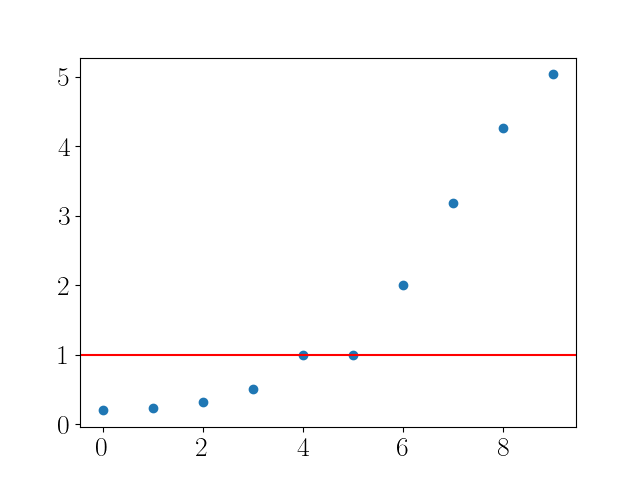

In [32]:
params = JosephsonParameters(W = 5 , 
                             L = 10,
                             t = 1,
                             flux = 0,
                             energy = 0,
                             Delta = 0,
                             phase = 0,
                             mu = 0.5,
                              tol = 1e-4)
F_pos , F_neg , debug_dict = so.calculate_transfer_matrices(0 , params)
evals = debug_dict['evals']
plt.figure()
plt.scatter(np.arange(len(evals)),np.sort(np.abs(evals)))
plt.axhline(y = 1 , color = 'r')

In [33]:
list_of_eigenvalues = debug_dict['list_of_eigenvalues']
pos_p_evals = list_of_eigenvalues[0]
neg_p_evals = list_of_eigenvalues[1]
print(np.angle(pos_p_evals))
print(np.angle(neg_p_evals))

[0.4865001]
[-0.4865001]


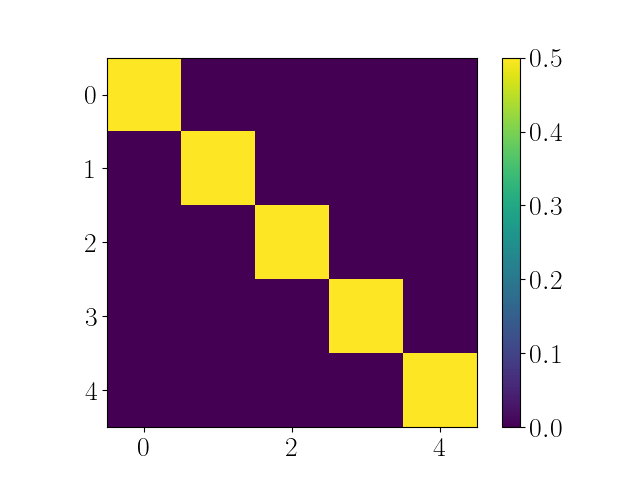

In [41]:
#Checking if modes are orthogonal:
U_neg = debug_dict['U_neg']
plt.figure()
test = U_neg.conj().T@ U_neg
plt.imshow(np.abs(test))
plt.colorbar()


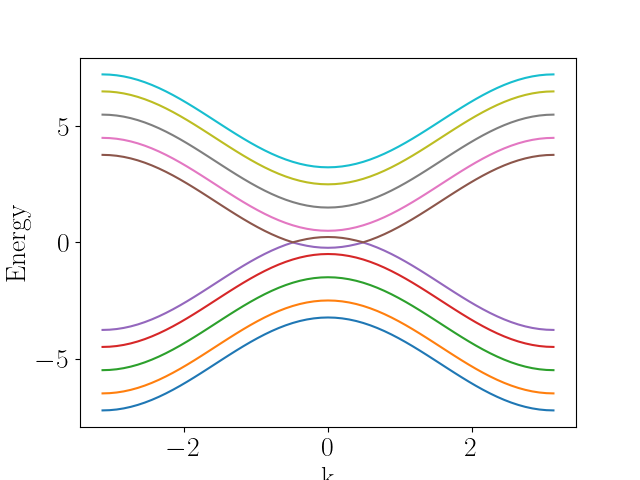

In [35]:
# Cross-checking with kwant:
sym = kwant.TranslationalSymmetry((-1 , 0))
lat = kwant.lattice.square(norbs = 2)
syst = kwant.Builder(sym)
for i in range(params.W):
    syst[lat(0 , i)] = 4*params.t*sz - params.mu*sz + params.Delta *sx
    if i > 0:
        syst[lat(0 , i), lat(0 , i-1)] = -params.t*sz
    syst[lat(1 , i) , lat(0 , i)] = -params.t*sz 

syst = syst.finalized()
kwant.plotter.bands(syst);
plt.axhline(y = params.energy , color = 'r')
plt.tight_layout()

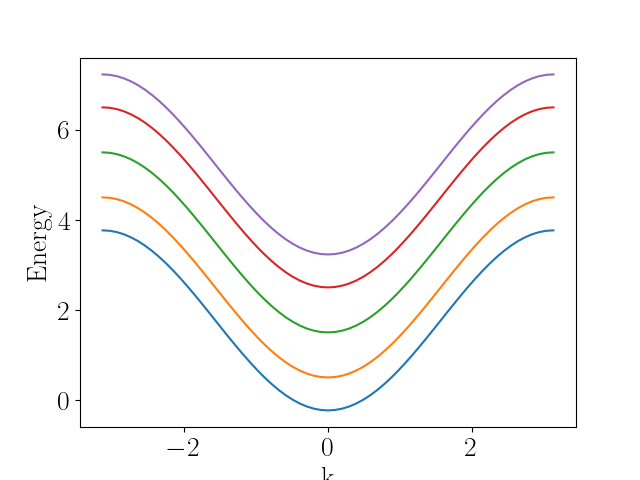

In [6]:
# Cross-checking with kwant:
sym = kwant.TranslationalSymmetry((-1 , 0))
lat = kwant.lattice.square(norbs = 1)
syst = kwant.Builder(sym)
for i in range(params.W):
    syst[lat(0 , i)] = 4*params.t - params.mu
    if i > 0:
        syst[lat(0 , i), lat(0 , i-1)] = -params.t
    syst[lat(1 , i) , lat(0 , i)] = -params.t

syst = syst.finalized()
kwant.plotter.bands(syst);
plt.axhline(y = params.energy , color = 'r')
plt.tight_layout()

In [42]:
def so_compute_conductance(params , eta = 1e-5):
    F_pos_0 , F_neg_0 , debug0 = so.calculate_transfer_matrices(0 , params)
    F_pos_Lplusone , F_neg_Lplusone , debug_Lplusone = so.calculate_transfer_matrices(params.L+1 , params)

    # Initial diagonal Green's function in the left-lead at slice 0:
    H_0_tilde = so.h_0(0 , params) + so.T(0 , +1 , params)@np.linalg.inv(F_neg_0)
    G_0 = np.linalg.inv(params.energy*np.identity(params.W) - (H_0_tilde))

    H_Lplusone_tilde = so.h_0(params.L+1 , params) + so.T(params.L+2 , -1 , params)@F_pos_Lplusone
    G_Lplusone = np.linalg.inv(params.energy*np.identity(params.W) - (H_Lplusone_tilde))

    # Recursion:
    no_steps = params.L + 2
    diag_greensfunctions = np.zeros(shape = (params.W , params.W , no_steps))
    off_diag_greensfunctions = np.zeros(shape = (params.W , params.W , no_steps))
    # Initial condition:
    diag_greensfunctions[: , : , 0] = G_0
    off_diag_greensfunctions[: , : , 0] = G_0

    # Storing tilde Hamiltonians in a list:
    H_tildes = np.zeros(shape = ( H_0_tilde.shape[0] , H_0_tilde.shape[0] , no_steps))
    H_tildes[: , : , 0] = H_0_tilde
    H_tildes[: , : ,-1] = H_Lplusone_tilde
    for j in range(1,params.L + 1):
        H_tildes[: , : , j] = so.h_0(j , params)


    for i in range(no_steps):
        if i > 0:
            matrix = (params.energy*np.identity(params.W)  - H_tildes[: , : , i] -
                                                        so.T(i , +1 , params) @ diag_greensfunctions[: , : , i-1] @ so.T(i , -1 , params) )
            # print(np.abs(np.linalg.det(matrix)))
            diag_greensfunctions[: , : , i] = np.linalg.inv(matrix)
            off_diag_greensfunctions[: , : , i] = diag_greensfunctions[: , : , i]@ so.T(i , +1 , params) @ off_diag_greensfunctions[: , : , i-1]

    ## Transmission matrix:
    U_pos_0 = debug0['U_pos']
    U_neg_0 = debug0['U_neg']

    U_pos_Lplusone = debug_Lplusone['U_pos']
    U_neg_Lplusone = debug_Lplusone['U_neg']
    transmissionmatrix = np.linalg.inv(U_pos_0)@off_diag_greensfunctions[: , : , -1]@so.T(0 , +1 , params)@(np.linalg.inv(F_pos_0) - 
                                                                                                       np.linalg.inv(F_neg_0))@U_pos_0
    print(np.abs(np.linalg.det(np.linalg.inv(U_pos_0))))
    print(np.abs(np.linalg.det(np.linalg.inv(F_pos_0))))
    reflectionmatrix = np.linalg.inv(U_neg_0)@(diag_greensfunctions[: , : , 0]@so.T(0 , +1 , params)@(np.linalg.inv(F_pos_0) - 
                                                                                                       np.linalg.inv(F_neg_0)) - np.identity(params.L))@U_pos_0

    conductance = np.trace(np.transpose(np.conjugate(transmissionmatrix)) @ transmissionmatrix)
    return conductance , transmissionmatrix, G_0 , G_Lplusone

In [10]:
energy_values = np.linspace(0 , 1 , 101)
conductance_values = np.zeros(energy_values.shape[0])
# Storing left and right Green's functions:
g_l = []
g_r = []
for i in range(len(energy_values)):
    params_new = JosephsonParameters(W = 10 , 
                             L = 10,
                             t = 1,
                             flux = 0,
                             energy = energy_values[i] ,
                             Delta = 0,
                             phase = 0,
                             mu = 0.5,
                             tol = 1e-4)
    conductance_values[i] , transmissionmatrix , G_0 , G_Lplusone= so_compute_conductance(params_new , eta = 0)
    g_l.append(G_0)
    g_r.append(G_Lplusone)

31.999999999999996
16760.50634452742
32.00000000000007
16214.54548904549
31.999999999999915
15679.509385828413
32.00000000000013
15155.026698334574
31.999999999999872
14640.703377951231
31.999999999999986
14136.116052372221
32.00000000000004
13640.803175200295
32.00000000000004
13154.252943605408
31.999999999999872
12675.88642947476
32.0
12205.033409247693
31.999999999999943
11740.896664794624
31.99999999999986
11282.497317942612
31.999999999999957
10828.58738020617
32.00000000000007
10377.502063782824
32.00000000000013
9926.892499772941
32.0
9473.195554452506
32.0
9010.437874299723
32.00000000000007
8526.952216949094
338501478185734.5
3.2256767929609514e-05
157998132159714.56
4.313060659437783e-05
31.999999999999986
6883.838790179433
32.00000000000003
6719.164005350145
31.99999999999997
6557.447814320275
32.0000000000001
6398.644826361589
32.0000000000001
6242.709996007122
32.0000000000001
6089.598606673567
31.999999999999872
5939.26625284785
31.999999999999872
5791.6688206297
31.9999

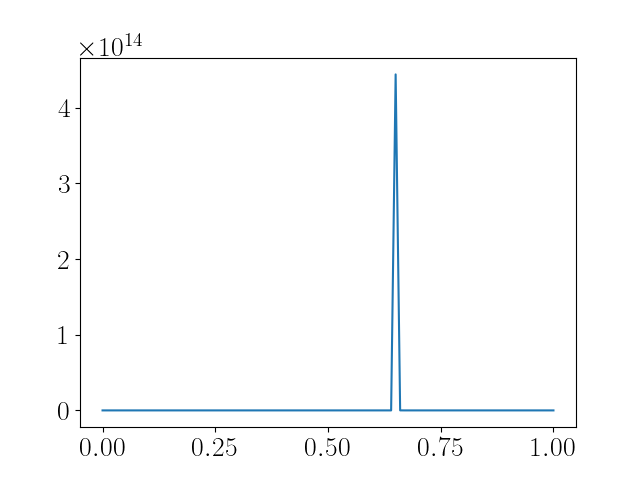

In [44]:
plt.figure()
plt.plot(energy_values , conductance_values)

In [49]:
np.array([[1 , 1],[1 , -1]])@np.array([[1 , 1],[1 , -1]])

array([[2, 0],
       [0, 2]])